#### 모듈 불러오기

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)

#### 데이터 불러오기

In [78]:
# 추정 매출 
buy_data = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_수정본.csv')
buy_data = buy_data.iloc[:,1:]

year_month = []
for i in range(buy_data.shape[0]):
    year_month.append(str(buy_data['기준_년_코드'].iloc[i]) + '-' + str(buy_data['기준_분기_코드'].iloc[i]))

buy_data['년-분기'] = year_month

# 대학 상권 list
college_commercial = pd.read_csv('./Data/대학인근상권.csv')

In [79]:
print("----- 상권 내용 분석 ----- \n")

college_cm_name = list(college_commercial['TRDAR_CD_N'].unique())
buy_data_cm_data = list(buy_data['상권_코드_명'].unique())

print("추청매출 데이터(서울 상권 분석 서비스)의 상권 개수: {}개".format(len(buy_data_cm_data)))
print("추출한 대학 상권 개수: {}개".format(len(college_cm_name)))
print("대학 상권의 비율: {:.2f}%".format(len(college_cm_name) / len(buy_data_cm_data)))

print("대학 상권에만 있는 상권 list: {} \n".format(list(set(college_cm_name).difference(set(buy_data_cm_data)))))

----- 상권 내용 분석 ----- 

추청매출 데이터(서울 상권 분석 서비스)의 상권 개수: 1480개
추출한 대학 상권 개수: 317개
대학 상권의 비율: 0.21%
대학 상권에만 있는 상권 list: ['신촌로28가길', '숭문8길'] 



In [80]:
print("---- 각 분기별 등장하는 상권의 개수 확인 ----")

display(buy_data.drop_duplicates(['년-분기','상권_코드_명']).groupby('년-분기')['상권_코드_명'].count())
display(buy_data.drop_duplicates(['년-분기','상권_코드_명']).groupby('년-분기')['상권_코드_명'].count().value_counts())

store_202101 = set(buy_data[buy_data['년-분기'] == "2021-1"].상권_코드_명.unique())
store_202004 = set(buy_data[buy_data['년-분기'] == "2020-4"].상권_코드_명.unique())

print("\n---- 2020-4분기에만 등장하는 상권 확인----")

print("2020-4분기만 등장하는 상권 list: {} \n".format(list(set(store_202101).difference(set(store_202004)))))
print("2020-4분기만 등장하는 상권 list: {} \n".format(list(set(store_202004).difference(set(store_202101)))))

---- 각 분기별 등장하는 상권의 개수 확인 ----


년-분기
2016-1    1479
2016-2    1479
2016-3    1479
2016-4    1479
2017-1    1479
          ... 
2020-2    1479
2020-3    1479
2020-4    1479
2021-1    1479
2021-2    1479
Name: 상권_코드_명, Length: 22, dtype: int64

1479    22
Name: 상권_코드_명, dtype: int64


---- 2020-4분기에만 등장하는 상권 확인----
2020-4분기만 등장하는 상권 list: ['종로?청계 관광특구'] 

2020-4분기만 등장하는 상권 list: ['종로·청계 관광특구'] 



In [81]:
buy_data['상권_코드_명'] = buy_data['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

#### 시계열 데이터 Clustering

- 참고 사이트: https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3
- 참고 사이트: https://tootouch.github.io/contest%20review/kdx_dashboard_part2/

In [82]:
# 대학상권만 가져오기
machul = buy_data[buy_data['상권_코드_명'].isin(college_cm_name)]
machul = machul.reset_index(drop=True)

# 상권별 분기 매출금액
df = machul.groupby(['상권_코드_명', '년-분기'])['분기당_매출_금액'].sum().reset_index()
df = df.rename(columns = {'분기당_매출_금액': '분기당_평균매출금액'})

# seed 고정
seed = 0
np.random.seed(seed)

df.head()

,상권_코드_명,년-분기,분기당_평균매출금액
0,가재울로6길,2016-1,4.558869e+09
1,가재울로6길,2016-2,4.842797e+09
2,가재울로6길,2016-3,5.084788e+09
3,가재울로6길,2016-4,5.028627e+09
4,가재울로6길,2017-1,4.532507e+09


In [83]:
temp_0 = df.set_index(['년-분기','상권_코드_명'])['분기당_평균매출금액'].unstack().transpose()
temp_0.head(1)

년-분기,2016-1,2016-2,2016-3,2016-4,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1,2021-2
상권_코드_명,,,,,,,,,,,,,,,,,,,,,,
가재울로6길,4.558869e+09,4.842797e+09,5.084788e+09,5.028627e+09,4.532507e+09,5.144975e+09,5.279706e+09,5.382834e+09,5.017325e+09,5.413768e+09,5.569011e+09,6.204531e+09,5.040723e+09,5.061176e+09,5.354570e+09,5.772536e+09,5.461024e+09,6.260351e+09,5.806272e+09,5.730111e+09,5.215420e+09,5.949536e+09


### (1)-1 분기 변화량에 대한 Kmean clustering

- 분기 변화량: 해당 년도 분기 - 이전 년도 분기

In [84]:
commercial_list = list(temp_0.index)   # 상권 list 가져오기
quater_name = list(temp_0.columns)[4:] # 분기 columns 가져오기
change = []

# 변화량 (ex: 2017 1분기 - 2016 1분기, 2017 2분기 - 2016 2분기)
for i in range((temp_0.shape[1] - 4)):
    change.append((temp_0.iloc[:,i + 4] - temp_0.iloc[:,i]))

temp_0 = pd.concat(change, axis = 1)
temp_0.columns = quater_name 
temp_0.head(2)

temp_final = temp_0.copy()

In [85]:
temp_final = temp_final.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
temp_final.head()

,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1,2021-2
상권_코드_명,,,,,,,,,,,,,,,,,,
가재울로6길,-0.476834,0.293456,0.041977,0.415443,0.721675,0.215184,0.263275,1.511517,-0.360168,-1.241709,-0.917801,-1.427877,0.570408,2.396547,0.644030,-0.514496,-0.990868,-1.143760
가좌로7길,0.058664,1.042289,0.730897,0.422562,0.762697,0.447398,0.108354,1.989177,-0.810415,-1.049348,-0.315473,-2.835808,-0.117508,0.064102,-0.326825,0.464155,-0.372321,-0.262597
갈현로1길,1.021579,1.030671,1.347315,0.525116,0.105905,0.213067,0.308031,1.277802,-1.173910,-1.055310,-1.458858,-2.496708,-0.210107,0.107325,0.128081,0.272443,0.121791,-0.064234
갈현로7길,1.042779,1.797167,1.371692,0.832502,0.519617,0.207240,-0.113281,0.074340,-1.290133,-1.645255,-1.410416,-1.012583,0.493877,0.775957,0.333592,-0.364577,-0.788098,-0.824420
강남시장_동작,-0.074167,-0.020185,-0.099825,-0.185452,-0.103233,0.311297,0.497370,1.021220,0.276656,-0.496143,2.245879,0.933432,0.520164,0.672705,-2.127352,-1.517455,-1.072698,-0.782212


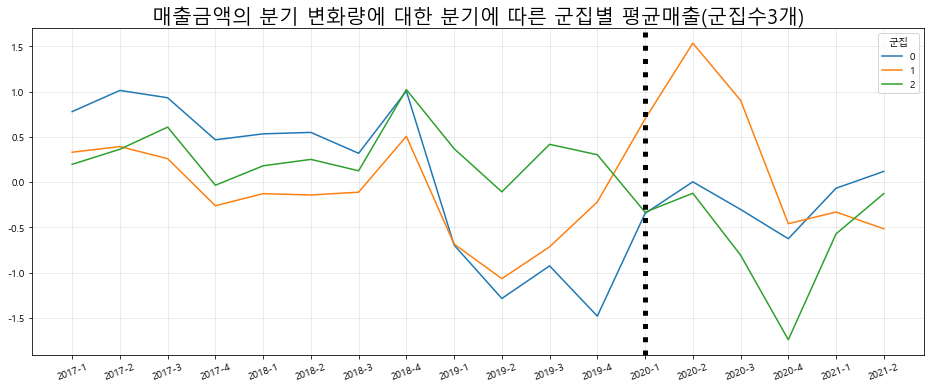

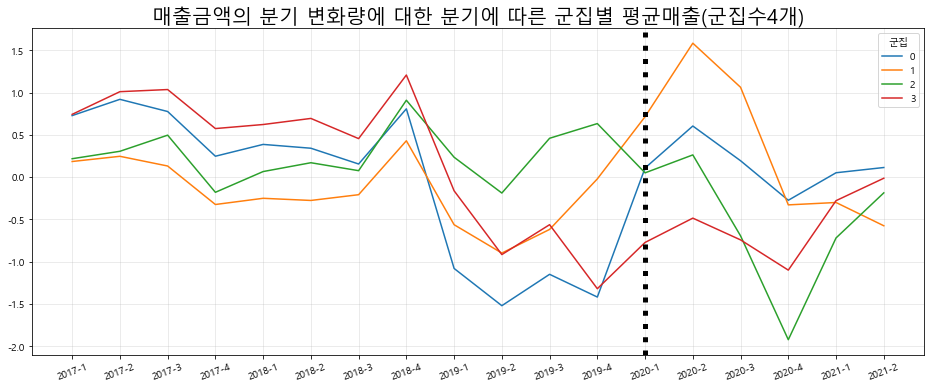

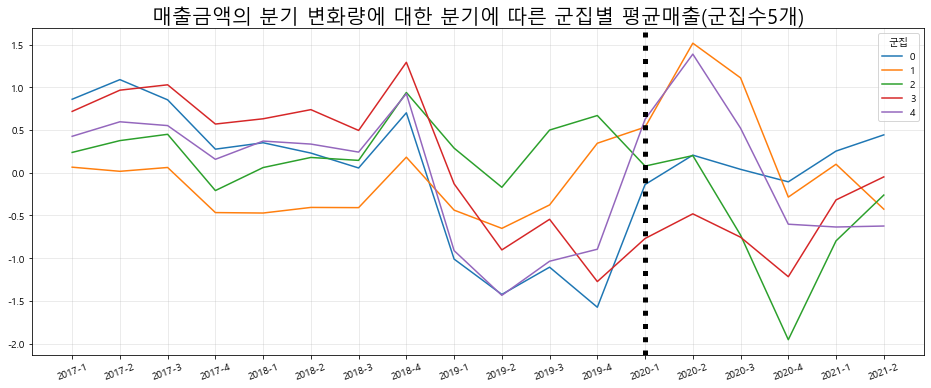

In [86]:
for i in range(3,6):
    temp_kmean_total_change = temp_final.copy()
    kmeans = KMeans(n_clusters=i, random_state=0).fit(temp_kmean_total_change)
    temp_kmean_total_change['segment'] = kmeans.labels_
    ax = temp_kmean_total_change.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(temp_kmean_total_change.columns)-1)], temp_kmean_total_change.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.axvline(x = 12, color = 'black', linestyle = ':',linewidth=5)
    plt.grid(alpha=0.3)
    plt.title('매출금액의 분기 변화량에 대한 분기에 따른 군집별 평균매출(군집수{}개)'.format(i) ,size=20)
    plt.show()

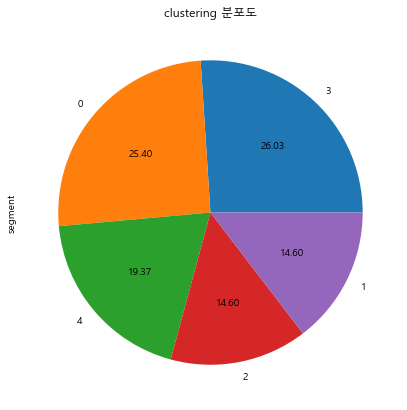

In [87]:
temp_kmean_total_change.segment.value_counts().plot(kind='pie', title = "clustering 분포도",figsize = (14,7),autopct='%.2f')
plt.show()

In [88]:
temp_kmean_total_change.segment.value_counts()

3    82
0    80
4    61
2    46
1    46
Name: segment, dtype: int64

### (1)-2 분기 변화량에 대한 DTW

- 분기 변화량: 해당 년도 분기 - 이전 년도 분기
- 군집별 추세 유사도가 mean보다는 더 심해서 사용하기 힘들듯 

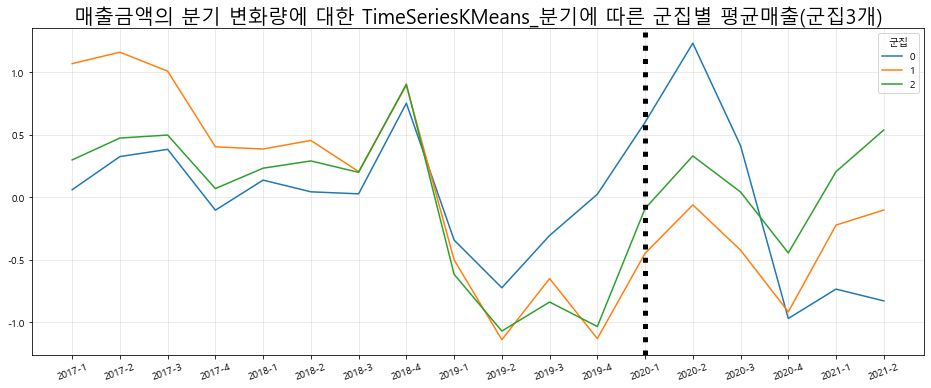

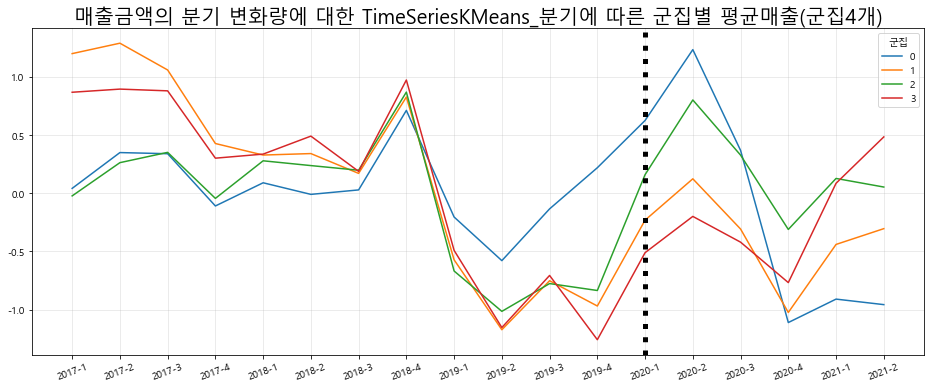

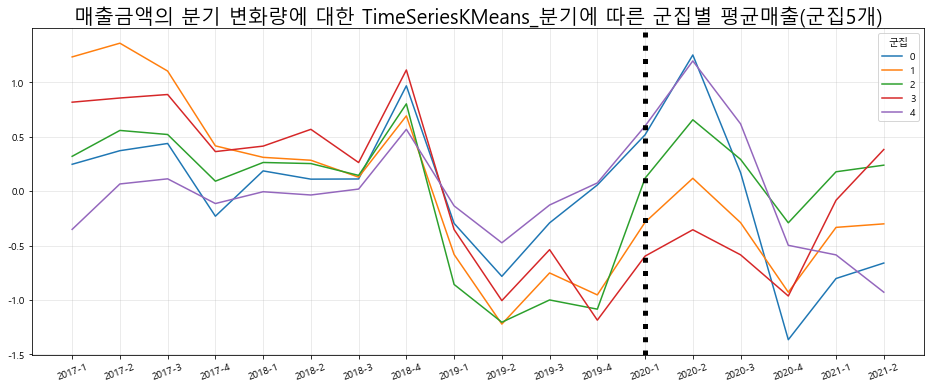

In [90]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

temp_dtw_total_change = temp_final.copy()
X = temp_dtw_total_change.to_numpy().reshape(315,18,1)

for k in range(3,6):
    km = TimeSeriesKMeans(n_clusters=k, 
                      metric="dtw", 
                      max_iter=10,
                      random_state=42)

    prediction = km.fit_predict(X)
    temp_dtw_total_change['segment'] = prediction
    ax = temp_dtw_total_change.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(temp_dtw_total_change.columns)-1)], temp_dtw_total_change.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.grid(alpha=0.3)
    plt.axvline(x = 12, color = 'black', linestyle = ':',linewidth=5)
    plt.title('매출금액의 분기 변화량에 대한 TimeSeriesKMeans_분기에 따른 군집별 평균매출(군집{}개)'.format(k),size=20)
    plt.show()

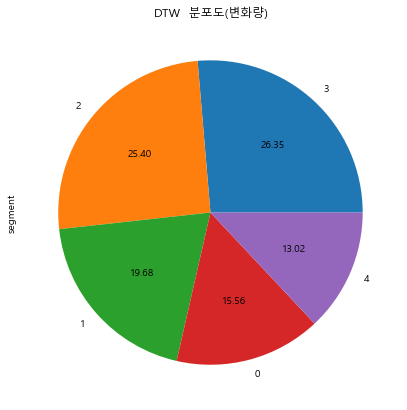

In [91]:
temp_dtw_total_change['segment'].value_counts().plot(kind='pie', title = "DTW  분포도(변화량)",figsize = (14,7),autopct='%.2f')
plt.show()

### (2)-1. 변화율 활용

- 모든 값을 2016년 1분기를 기준 point로 잡은 이후에 다른 분기를 2016년 분기 대비 변화율로 봄

- 해석: 0보다 크면 2016년 1분기보다 매출이 증가한 거를 의미 / 그래프가 우상향이 되는 것은 점점 매출이 증가하고 있음을 의미

In [92]:
temp_1 = df.set_index(['년-분기','상권_코드_명'])['분기당_평균매출금액'].unstack().transpose()

begin_point = temp_1.T.iloc[0,:]
value = temp_1.T.div(begin_point).sub(1).round(2).mul(100).T

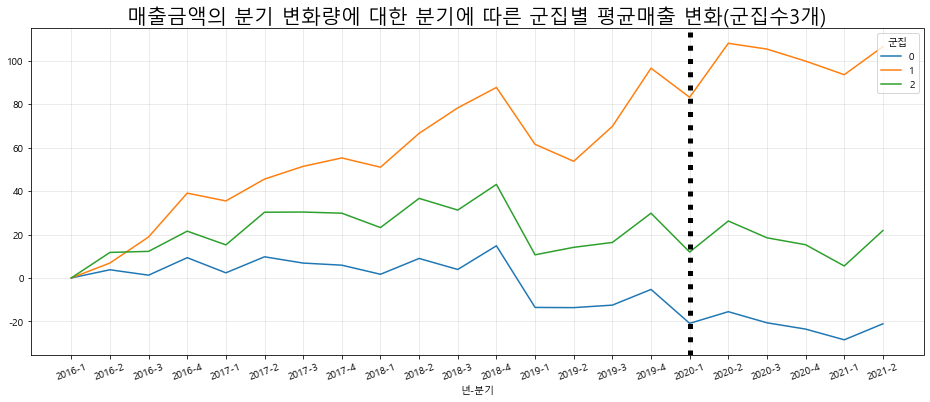

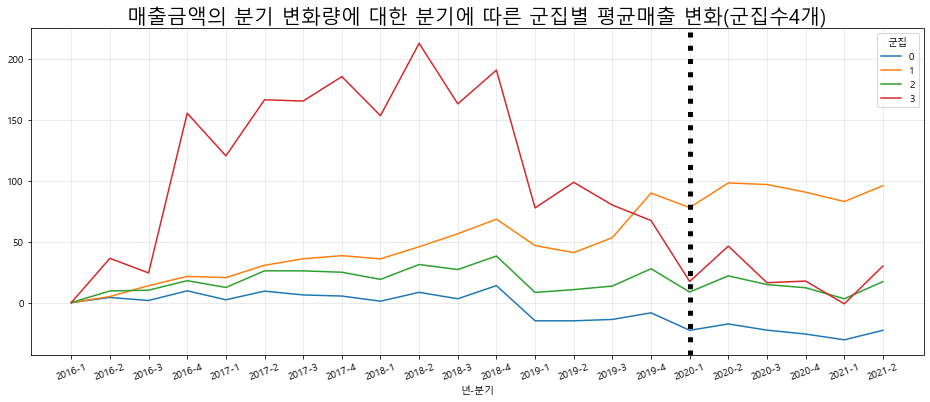

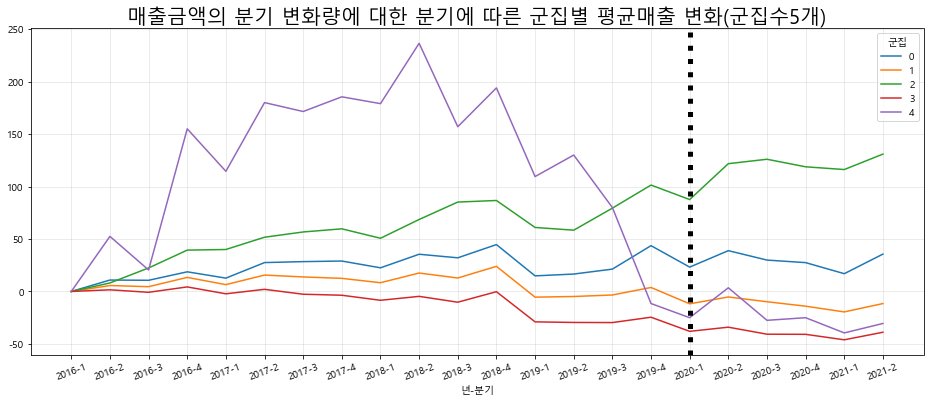

In [93]:
for i in range(3,6):
    a = value.copy()
    kmeans = KMeans(n_clusters=i, random_state=0).fit(a)
    a['segment'] = kmeans.labels_
    ax = a.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(a.columns)-1)], a.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.axvline(x = 16, color = 'black', linestyle = ':',linewidth=5)
    plt.grid(alpha=0.3)
    plt.title('매출금액의 분기 변화량에 대한 분기에 따른 군집별 평균매출 변화(군집수{}개)'.format(i) ,size=20)
    plt.show()

In [94]:
a['segment'].value_counts()

1    172
0     74
3     57
2     10
4      2
Name: segment, dtype: int64

In [95]:
a.query('segment == 3')

년-분기,2016-1,2016-2,2016-3,2016-4,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1,2021-2,segment
상권_코드_명,,,,,,,,,,,,,,,,,,,,,,,
강서구청,0.0,-1.0,2.0,6.0,2.0,4.0,4.0,6.0,0.0,-3.0,-6.0,5.0,-25.0,-28.0,-23.0,-16.0,-26.0,-27.0,-32.0,-41.0,-51.0,-43.0,3
경희대학교,0.0,14.0,-1.0,15.0,-1.0,18.0,4.0,13.0,-2.0,11.0,-8.0,14.0,-18.0,-14.0,-19.0,-13.0,-36.0,-29.0,-35.0,-34.0,-42.0,-32.0,3
고척로52길,0.0,-2.0,6.0,7.0,-5.0,10.0,0.0,-6.0,-14.0,22.0,26.0,47.0,-9.0,8.0,-9.0,-74.0,-73.0,-62.0,-65.0,-63.0,-60.0,-50.0,3
공릉로58길,0.0,8.0,0.0,18.0,-5.0,6.0,7.0,6.0,-11.0,0.0,-3.0,6.0,-25.0,-19.0,-19.0,-12.0,-26.0,-23.0,-26.0,-25.0,-24.0,-15.0,3
남부순환로97길,0.0,0.0,2.0,10.0,4.0,3.0,2.0,4.0,3.0,4.0,-2.0,10.0,-11.0,-20.0,-16.0,-14.0,-36.0,-15.0,-21.0,-24.0,-27.0,-24.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
홍연길,0.0,1.0,38.0,41.0,37.0,42.0,45.0,36.0,41.0,39.0,40.0,44.0,-74.0,-75.0,-74.0,-75.0,-74.0,-75.0,-76.0,-74.0,-79.0,-76.0,3
홍익대학교 주변,0.0,6.0,6.0,13.0,11.0,15.0,14.0,12.0,6.0,12.0,9.0,18.0,-13.0,-24.0,-12.0,-2.0,-28.0,-32.0,-34.0,-40.0,-48.0,-35.0,3
화곡로59길,0.0,3.0,4.0,2.0,5.0,4.0,8.0,6.0,9.0,21.0,22.0,20.0,-33.0,-29.0,-22.0,-39.0,-42.0,-34.0,-35.0,-47.0,-49.0,-46.0,3


### (2)-2. 분기 변화율 활용:가능할지는 고민

- 위의 변화율을 2016년 1분기 기준이 아니라서 각 분기를 2016년을 기준으로 진행 
- (다시 표현하자면 1분기는 2016년 1분기 기준 변화율, 2분기는 2016년 2분기 기준 변화율 계산)

In [96]:
temp_2 = df.set_index(['년-분기','상권_코드_명'])['분기당_평균매출금액'].unstack().transpose()

quarter_1 = ['2016-1','2017-1','2018-1','2019-1','2020-1','2021-1']
quarter_2 = ['2016-2','2017-2','2018-2','2019-2','2020-2','2021-2']
quarter_3 = ['2016-3','2017-3','2018-3','2019-3','2020-3']
quarter_4 = ['2016-4','2017-4','2018-4','2019-4','2020-4']

part_1 = temp_2.loc[:,quarter_1]
begin_point_part1 = part_1.T.iloc[0,:]
value_part1 = part_1.T.div(begin_point_part1).sub(1).round(2).mul(100).T

part_2 = temp_2.loc[:,quarter_2]
begin_point_part2 = part_2.T.iloc[0,:]
value_part2 = part_2.T.div(begin_point_part2).sub(1).round(2).mul(100).T

part_3 = temp_2.loc[:,quarter_3]
begin_point_part3 = part_3.T.iloc[0,:]
value_part3 = part_3.T.div(begin_point_part3).sub(1).round(2).mul(100).T

part_4 = temp_2.loc[:,quarter_4]
begin_point_part4 = part_4.T.iloc[0,:]
value_part4 = part_4.T.div(begin_point_part4).sub(1).round(2).mul(100).T

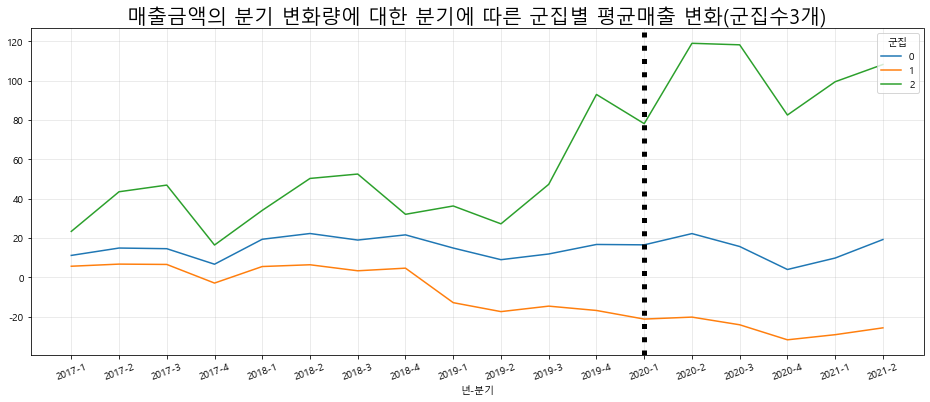

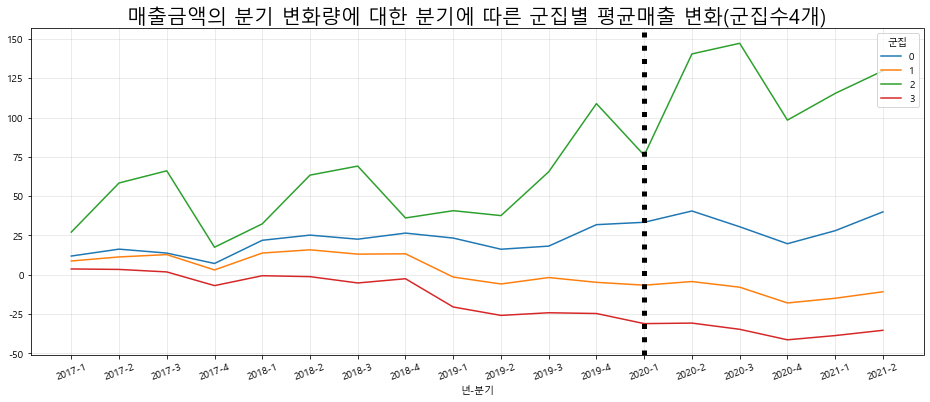

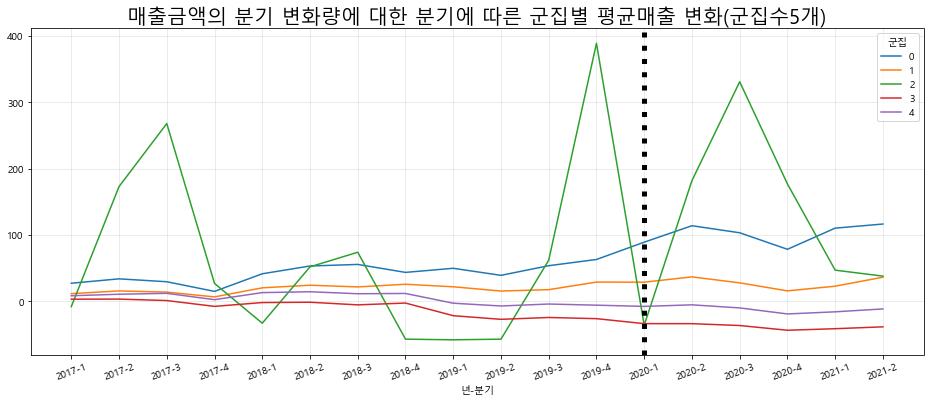

In [97]:
value_individual = pd.concat([value_part1,value_part2,value_part3,value_part4], axis = 1).loc[:,list(temp_2.columns)].iloc[:,4:]

for i in range(3,6):
    b = value_individual.copy()
    kmeans = KMeans(n_clusters=i, random_state=0).fit(b)
    b['segment'] = kmeans.labels_
    ax = b.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(b.columns)-1)], b.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.axvline(x = 12, color = 'black', linestyle = ':',linewidth=5)
    plt.grid(alpha=0.3)
    plt.title('매출금액의 분기 변화량에 대한 분기에 따른 군집별 평균매출 변화(군집수{}개)'.format(i) ,size=20)
    plt.show()

<AxesSubplot:xlabel='년-분기'>

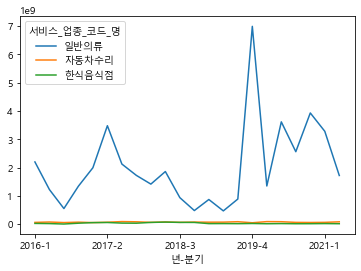

In [104]:
buy_data.query('상권_코드_명 == "동호로20길"').pivot_table(columns ='년-분기', index = '서비스_업종_코드_명', aggfunc = 'sum', values = '분기당_매출_금액').T.plot()

<AxesSubplot:xlabel='년-분기'>

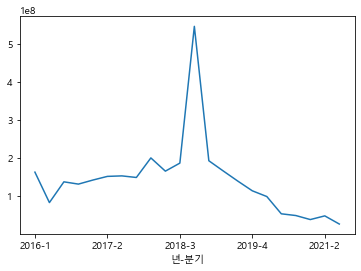

In [171]:
machul.query('서비스_업종_코드_명 =="PC방" and 상권_코드_명 == "강서구청"').set_index('년-분기')['분기당_매출_금액'].plot()

In [179]:
temp_0

,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1,2021-2
상권_코드_명,,,,,,,,,,,,,,,,,,
가재울로6길,-2.636222e+07,3.021774e+08,1.949180e+08,354206360.0,484818748.0,268793142.0,289304520.0,8.216974e+08,2.339779e+07,-3.525916e+08,-2.144404e+08,-4.319952e+08,4.203010e+08,1.199175e+09,4.517020e+08,-4.242526e+07,-2.456046e+08,-3.108151e+08
가좌로7길,-5.001144e+07,4.804899e+08,3.125460e+08,146250948.0,329696868.0,159645902.0,-23212015.0,9.911782e+08,-5.187343e+08,-6.475991e+08,-2.517959e+08,-1.611096e+09,-1.450265e+08,-4.707859e+07,-2.579182e+08,1.686834e+08,-2.824558e+08,-2.232783e+08
갈현로1길,1.137720e+09,1.147914e+09,1.502927e+09,581097166.0,111087821.0,231235900.0,337706509.0,1.424990e+09,-1.323809e+09,-1.190837e+09,-1.643286e+09,-2.806898e+09,-2.432171e+08,1.126802e+08,1.359513e+08,2.978065e+08,1.288992e+08,-7.966805e+07
갈현로7길,6.137769e+08,1.129852e+09,8.387854e+08,469926694.0,255882468.0,42185828.0,-177081753.0,-4.873077e+07,-9.821641e+08,-1.225103e+09,-1.064450e+09,-7.922924e+08,2.382737e+08,4.312443e+08,1.286230e+08,-3.489929e+08,-6.387229e+08,-6.635705e+08
강남시장_동작,-9.122242e+06,8.966500e+04,-1.350060e+07,-28112493.0,-14082214.0,56655478.0,88407944.0,1.778006e+08,5.074409e+07,-8.113043e+07,3.867830e+08,1.628199e+08,9.229771e+07,1.183281e+08,-3.594888e+08,-2.554126e+08,-1.795169e+08,-1.299468e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
휘경로2길,7.671682e+08,9.226624e+08,9.025312e+08,-9784286.0,347132276.0,305238075.0,-64582722.0,2.047848e+09,-7.755268e+08,-2.052096e+09,-1.565133e+09,-3.116167e+09,-2.151052e+09,-2.466298e+09,-1.684011e+09,-2.985157e+09,-1.496607e+09,-1.220725e+09
휘경로3길,3.589939e+08,7.960813e+08,6.645041e+08,288785859.0,-55713401.0,-212909784.0,-423075146.0,1.272250e+08,-1.453736e+09,-2.511394e+09,-2.189752e+09,-5.457991e+08,-8.603508e+08,-5.665577e+08,-5.721206e+08,-2.917803e+09,-9.985971e+08,-5.219705e+08
흑석로13길,-6.402874e+07,-1.183120e+08,1.563344e+08,-42296783.0,-108160085.0,-7424187.0,-49976423.0,1.304660e+08,4.698436e+08,2.903022e+08,6.647243e+08,4.455337e+08,-2.154702e+08,-3.637769e+08,-7.725356e+08,-7.926999e+08,-4.922278e+08,-1.909216e+08


<AxesSubplot:xlabel='년-분기'>

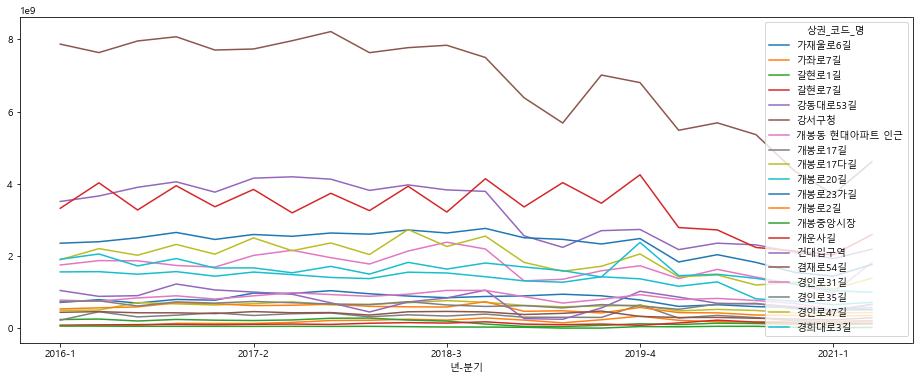

In [176]:
machul.query('서비스_업종_코드_명 =="한식음식점"').pivot_table(index = '상권_코드_명', columns ='년-분기',
             values = '분기당_매출_금액', aggfunc = 'sum').iloc[:20,:].T.plot(figsize = (16,6))

음식점류 : '한식음식점','양식음식점','분식전문점','패스트푸드점','중식음식점','치킨전문점','일식음식점',
디저트류: '커피-음료' ,'제과점'
소매점류: '슈퍼마켓','미곡판매', '육류판매','수산물판매',
주점류: '호프-간이주점',
오락류: '당구장','노래방','PC방','골프연습장'
미용뷰티류: '미용실','네일숍','화장품','피부관리실','

In [166]:
machul.서비스_업종_코드_명.value_counts().tail(20)

PC방           946
골프연습장         858
핸드폰           770
인테리어          770
서적            748
조명용품          704
운동/경기용품       616
애완동물          594
수산물판매         550
섬유제품          528
의료기기          484
컴퓨터및주변장치판매    462
가구            374
자동차미용         374
가전제품          374
가방            286
완구            220
가전제품수리        198
전자상거래업        176
고시원            44
Name: 서비스_업종_코드_명, dtype: int64

In [159]:
machul.서비스_업종_코드_명.unique()

array(['한식음식점', '편의점', '양식음식점', '분식전문점', '미용실', '제과점', '커피-음료', '한의원',
       '패스트푸드점', '가방', '일반의류', '슈퍼마켓', '중식음식점', '치과의원', '치킨전문점', '반찬가게',
       '세탁소', '일식음식점', '의약품', '핸드폰', '호프-간이주점', '예술학원', '당구장', '네일숍',
       '화초', '미곡판매', '육류판매', '일반의원', '노래방', '일반교습학원', '화장품', '피부관리실',
       '인테리어', '서적', 'PC방', '가전제품', '안경', '시계및귀금속', '애완동물', '컴퓨터및주변장치판매',
       '여관', '자동차수리', '문구', '외국어학원', '운동/경기용품', '철물점', '신발', '자동차미용',
       '청과상', '스포츠 강습', '골프연습장', '의료기기', '가전제품수리', '스포츠클럽', '수산물판매',
       '조명용품', '가구', '섬유제품', '완구', '고시원', '전자상거래업'], dtype=object)

<AxesSubplot:xlabel='년-분기'>

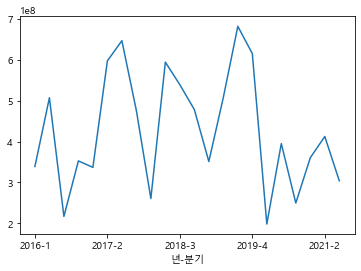

In [137]:
machul.query('서비스_업종_코드_명 =="일반의류" and 상권_코드_명 == "계동길"').set_index('년-분기')['분기당_매출_금액'].plot()

In [ ]:
machul.query('서비스_업종_코드_명 =="일반의류" and 상권_코드_명 == "계동길"')['분기당_매출_금액'].plot()

In [138]:
machul

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율,남성_매출_비율,여성_매출_비율,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,주중_매출_금액,주말_매출_금액,월요일_매출_금액,화요일_매출_금액,수요일_매출_금액,목요일_매출_금액,금요일_매출_금액,토요일_매출_금액,일요일_매출_금액,시간대_00~06_매출_금액,시간대_06~11_매출_금액,시간대_11~14_매출_금액,시간대_14~17_매출_금액,시간대_17~21_매출_금액,시간대_21~24_매출_금액,남성_매출_금액,여성_매출_금액,연령대_10_매출_금액,연령대_20_매출_금액,연령대_30_매출_금액,연령대_40_매출_금액,연령대_50_매출_금액,연령대_60_이상_매출_금액,주중_매출_건수,주말_매출_건수,월요일_매출_건수,화요일_매출_건수,수요일_매출_건수,목요일_매출_건수,금요일_매출_건수,토요일_매출_건수,일요일_매출_건수,시간대_건수~06_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,년-분기
0,2016,1,A,골목상권,1000001,계동길,CS100001,한식음식점,8.299479e+08,20596,67,33,11,13,14,14,15,18,15,2,0,34,19,35,9,53,47,1,26,30,23,14,6,5.821822e+08,2.477657e+08,89641804,1.201080e+08,119919068,128263751,124249613,135146665,112619042,22860757,14686345,2.708239e+08,1.267793e+08,2.910431e+08,103754471,3.501892e+08,2.479075e+08,3676997,127569036,174112189,1.415945e+08,101282323,49861610,14545,6051,2437,2880,2984,3123,3121,3144,2907,173,77,8665,4057,6539,1085,8826,7990,180,4800,4946,3792,2144,956,18,2016-1
1,2016,1,A,골목상권,1000001,계동길,CS300002,편의점,6.123313e+08,104491,74,26,14,14,15,15,15,14,13,7,22,18,17,22,14,62,39,4,33,30,20,9,4,4.578443e+08,1.544870e+08,86745146,9.578774e+07,89207774,90226227,95877436,83079228,71407749,50048928,113635025,1.067657e+08,9.278592e+07,1.451796e+08,103916084,3.295985e+08,1.816537e+08,10102470,136109743,164552059,1.179874e+08,54879528,27621015,76857,27634,14535,14743,15923,15741,15915,14433,13201,7620,22831,18525,17913,22793,14809,60044,37407,3831,32541,29373,19568,8582,3560,3,2016-1
2,2016,1,A,골목상권,1000001,계동길,CS100004,양식음식점,4.096594e+08,12487,68,32,9,13,15,14,18,17,15,0,0,45,23,30,2,48,52,2,44,31,13,8,3,2.511104e+08,1.585490e+08,31916634,5.369536e+07,56377503,47720046,61400899,87516615,71032365,0,295259,1.315288e+08,9.554109e+07,1.639377e+08,18356642,1.714356e+08,1.971202e+08,5763626,138700544,110717794,6.318880e+07,38025453,12159576,7589,4898,958,1506,1723,1520,1882,2677,2221,0,23,4106,3208,4842,308,5270,6261,264,4932,3263,1696,1044,335,7,2016-1
3,2016,1,A,골목상권,1000001,계동길,CS100008,분식전문점,1.505896e+08,10881,71,29,12,16,14,15,14,18,12,0,0,43,32,25,0,38,62,3,35,28,22,9,3,1.160903e+08,3.449924e+07,18810489,2.645392e+07,24583314,24393959,21848662,25052846,9446395,0,153994,7.931312e+07,3.488365e+07,3.610447e+07,134348,5.176137e+07,7.030109e+07,2522346,36000591,35067362,2.962393e+07,13800023,5048217,8297,2584,1311,1884,1722,1697,1683,1761,823,0,17,5467,2761,2627,9,3699,5563,243,3104,2766,1946,891,312,5,2016-1
4,2016,1,A,골목상권,1000001,계동길,CS200028,미용실,4.028348e+07,1606,75,25,14,15,13,17,16,22,4,0,3,24,37,34,3,46,54,3,12,17,35,19,13,2.695804e+07,1.332544e+07,6386665,3.597795e+06,5181969,5242149,6549459,12110524,1214918,0,693827,1.034680e+07,1.225374e+07,1.580697e+07,1182136,1.223462e+07,2.776620e+07,1014045,3895669,6779177,1.354021e+07,7516213,7255508,1187,419,236,228,215,250,258,362,57,0,44,394,571,552,45,724,868,55,189,282,571,292,205,5,2016-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125637,2021,1,U,관광특구,1001495,잠실 관광특구,CS100005,제과점,2.947490e+09,67301,68,32,19,10,8,22,10,17,15,0,6,22,52,19,1,47,30,0,8,19,29,11,11,2.001823e+09,9.456676e+08,558957190,2.792857e+08,223819586,650495127,289265023,497365338,448302231,0,180261068,6.401747e+08,1.534297e+09,5.681339e+08,24623576,1.394902e+09,8.874026e+08,132891,

In [129]:
round(machul.groupby('상권_코드_명')['점포수'].mean(),0).value_counts().sort_index().tail(-3).sum()

257

In [130]:
x

1.0       3
2.0      15
3.0      40
4.0      79
5.0      53
         ..
49.0      1
59.0      1
85.0      1
94.0      1
158.0     1
Name: 점포수, Length: 32, dtype: int64

In [110]:
buy_data.점포수.value_counts().sort_index().head(20)

0      2141
1     92716
2     97711
3     79687
4     60297
5     45245
6     34971
7     26776
8     20448
9     16571
10    13701
11    11043
12     9131
13     7625
14     6640
15     5772
16     5064
17     4178
18     3860
19     3490
Name: 점포수, dtype: int64

<AxesSubplot:xlabel='년-분기'>

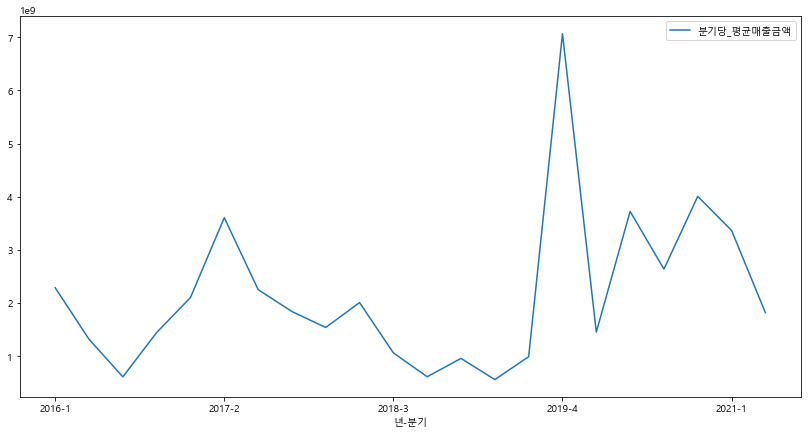

In [100]:
df.set_index('년-분기').query('상권_코드_명 == "동호로20길"').plot(figsize = (14,7))

In [61]:
b.query('segment == 2')

년-분기,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1,2021-2,segment
상권_코드_명,,,,,,,,,,,,,,,,,,,
동호로20길,-8.0,173.0,268.0,27.0,-33.0,52.0,74.0,-57.0,-58.0,-57.0,62.0,389.0,-36.0,182.0,331.0,177.0,47.0,38.0,2


In [ ]:
temp_dtw_total_change['segment'].value_counts().plot(kind='pie', title = "DTW  분포도(변화량)",figsize = (14,7),autopct='%.2f')
plt.show()

### (3)-1. 매출건수를 활용 / clusring: Kmeans()

- 매출 금액과 동일하게 분기별 약간의 계절성 특징이 나타남

In [36]:
df_cnt = machul.groupby(['상권_코드_명', '년-분기'])['분기당_매출_건수'].mean().reset_index().round(2)
df_cnt = df_cnt.rename(columns = {'분기당_매출_건수': '분기당_평균매출건수'})

In [37]:
temp_cnt = df_cnt.set_index(['년-분기','상권_코드_명'])['분기당_평균매출건수'].unstack().transpose()
temp_cnt0 = temp_cnt.copy()
temp_cnt0 = temp_cnt0.apply(lambda x: (x-x.mean())/x.std(), axis=1)

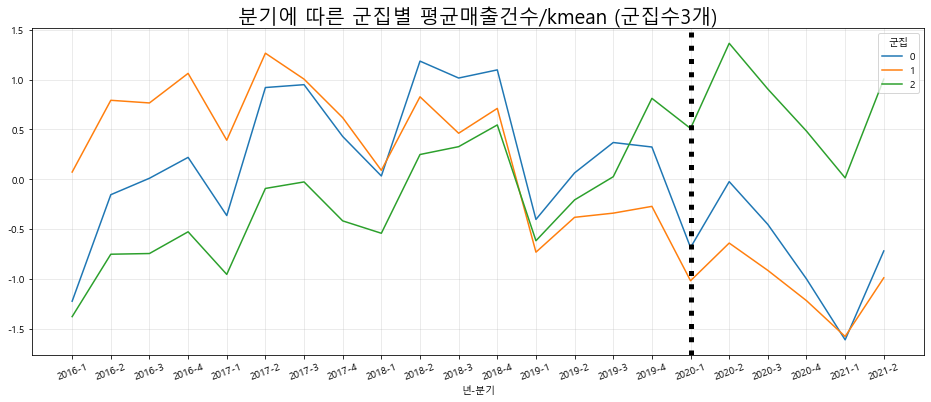

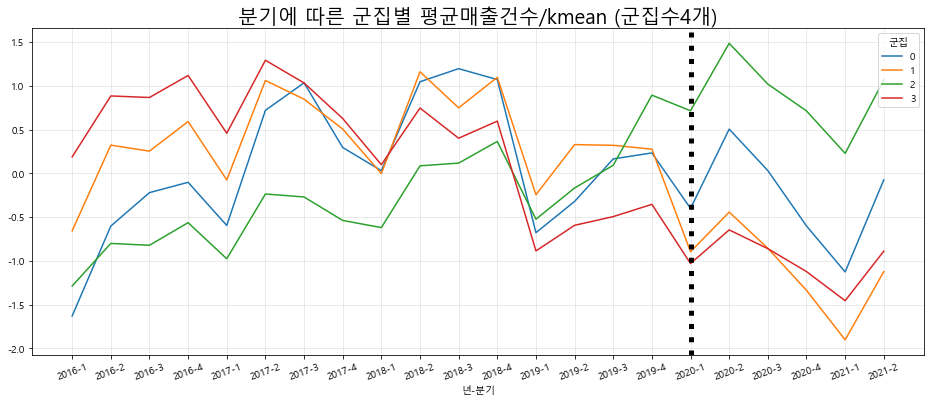

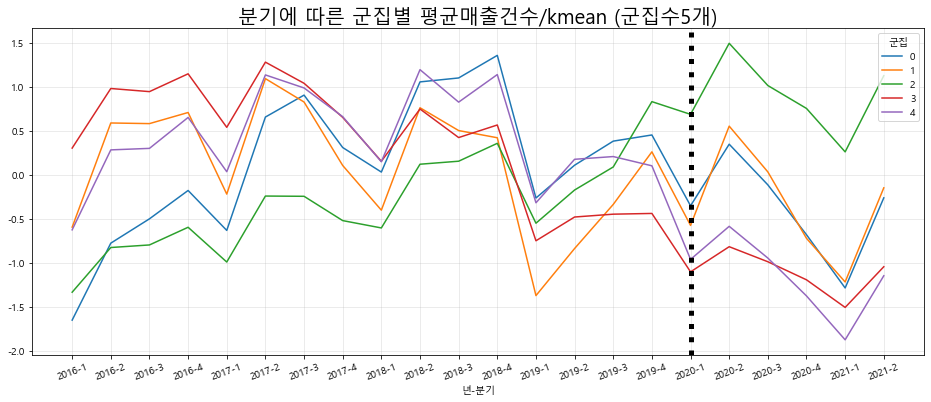

In [38]:
for i in range(3,6):
    temp_cnt_final_kmean = temp_cnt0.copy()
    kmeans = KMeans(n_clusters=i, random_state=0).fit(temp_cnt_final_kmean)
    temp_cnt_final_kmean['segment'] = kmeans.labels_
    ax = temp_cnt_final_kmean.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(temp_cnt_final_kmean.columns)-1)], temp_cnt_final_kmean.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.axvline(x = 16, color = 'black', linestyle = ':',linewidth=5)
    plt.grid(alpha=0.3)
    plt.title('분기에 따른 군집별 평균매출건수/kmean (군집수{}개)'.format(i) ,size=20)
    plt.show()

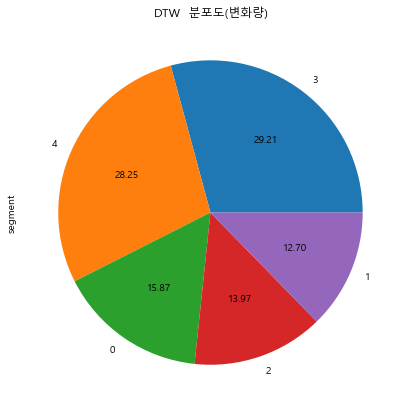

In [45]:
temp_cnt_final_kmean['segment'].value_counts().plot(kind='pie', title = "DTW  분포도(변화량)",figsize = (14,7),autopct='%.2f')
plt.show()

In [46]:
temp_cnt_final_kmean['segment'].value_counts()

3    92
4    89
0    50
2    44
1    40
Name: segment, dtype: int64

### (3)-2 매출건수를 활용 / clusring: drtw

- 매출 금액과 동일하게 분기별 약간의 계절성 특징이 나타남
    - 군집 3애일 경우; 추세가 지속적 감소 (노란색) vs 추세가 지속적 증가(초록색)

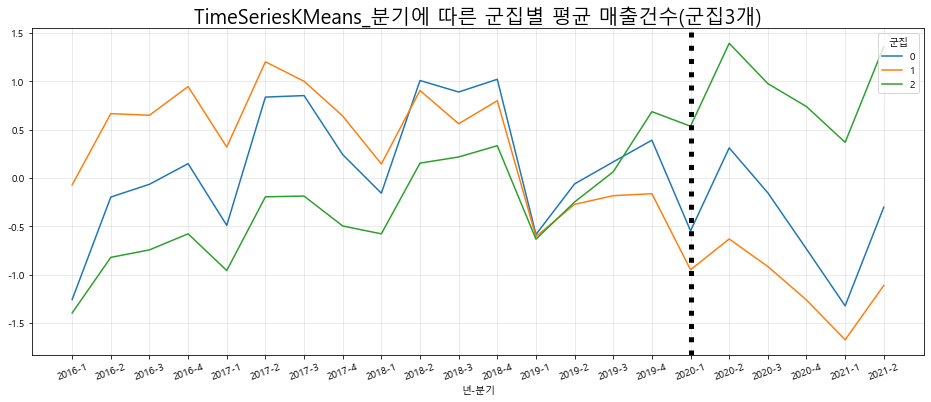

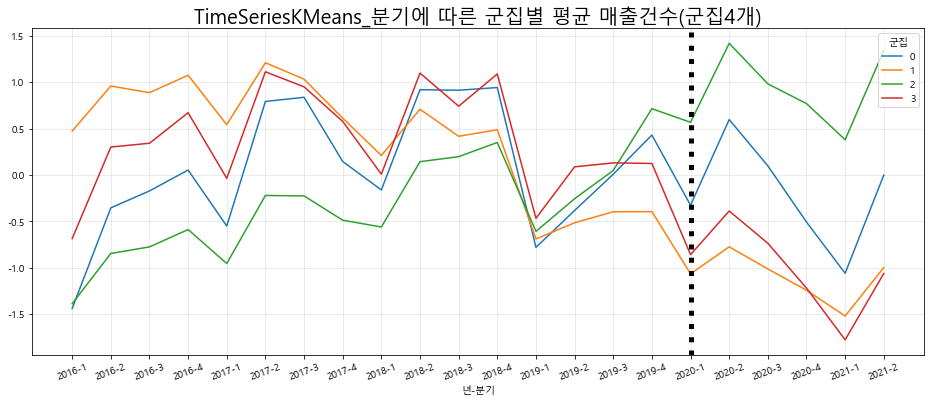

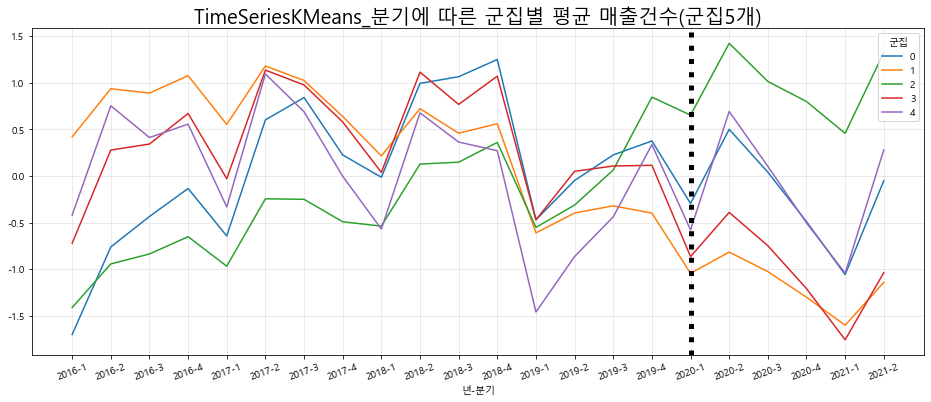

In [39]:
temp_4_cnt = temp_cnt0.copy()
X = temp_4_cnt.to_numpy().reshape(315,22,1)
for k in range(3,6):
    km = TimeSeriesKMeans(n_clusters=k, 
                      metric="dtw", 
                      max_iter=100,
                      random_state=42)

    prediction = km.fit_predict(X)
    temp_4_cnt['segment'] = prediction
    ax = temp_4_cnt.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(temp_4_cnt.columns)-1)], temp_4_cnt.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.grid(alpha=0.3)
    plt.axvline(x = 16, color = 'black', linestyle = ':',linewidth=5)
    plt.title('TimeSeriesKMeans_분기에 따른 군집별 평균 매출건수(군집{}개)'.format(k),size=20)
    plt.show()

In [54]:
r = pd.concat([temp_cnt_final_kmean['segment'], temp_4_cnt['segment']], axis = 1)

In [55]:
r.columns = [1,2]

In [57]:
r.reset_index().groupby([1,2]).count()

상권_코드_명
1 2         
0 0       34
  2        2
  3       14
1 0        3
  1        1
  3       12
  4       24
2 0        5
  2       36
  3        1
  4        2
3 0        1
  1       71
  3       19
  4        1
4 1       11
  3       78

### 4. 매출건수변화량을 활용 / clusring: Kmeans()

- 분기별 변화량: 위의 매출 금액과 동일한 수식을 진행

In [40]:
commercial_list = list(temp_cnt.index)   # 상권 list 가져오기
quater_name = list(temp_cnt.columns)[4:] # 분기 columns 가져오기
rate_of_change = []

# 변화율 (ex: 2017 1분기 - 2016 1분기, 2017 2분기 - 2016 2분기)
for i in range((temp_cnt.shape[1] - 4)):
    rate_of_change.append((temp_cnt.iloc[:,i + 4] - temp_cnt.iloc[:,i]))

temp_cnt_change = pd.concat(rate_of_change, axis = 1)
temp_cnt_change.columns = quater_name 
temp_cnt_change.head(2)

,2017-1,2017-2,2017-3,2017-4,2018-1,2018-2,2018-3,2018-4,2019-1,2019-2,2019-3,2019-4,2020-1,2020-2,2020-3,2020-4,2021-1,2021-2
상권_코드_명,,,,,,,,,,,,,,,,,,
가재울로6길,155.4,314.08,207.76,-288.64,29.44,-74.04,-331.00,857.52,-159.20,-1562.32,-486.64,-522.84,1833.92,2962.68,722.32,893.76,-958.56,-407.36
가좌로7길,504.0,1093.79,1026.58,298.21,608.22,679.79,288.63,1603.85,-361.58,-3224.89,-1407.00,-1736.64,168.73,1547.89,-743.16,-765.00,-1558.15,-913.74


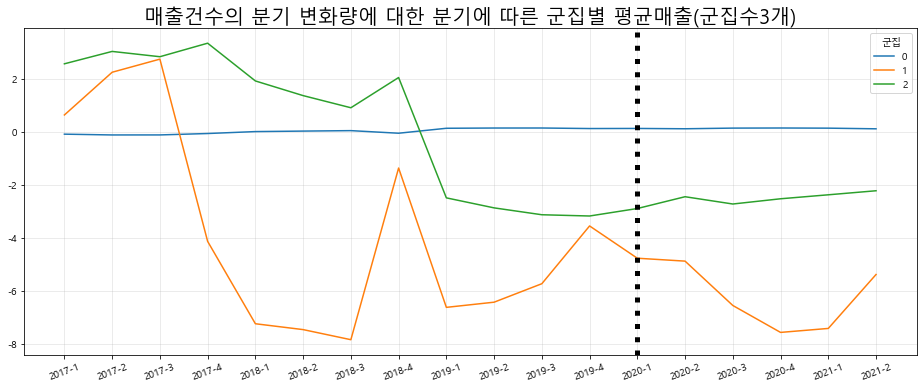

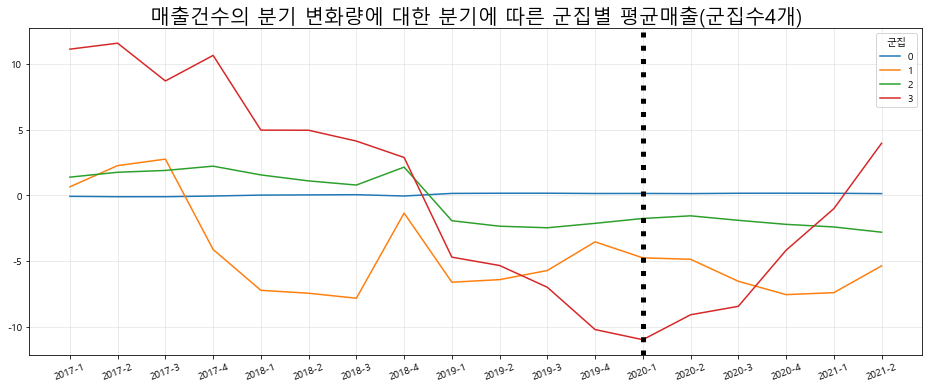

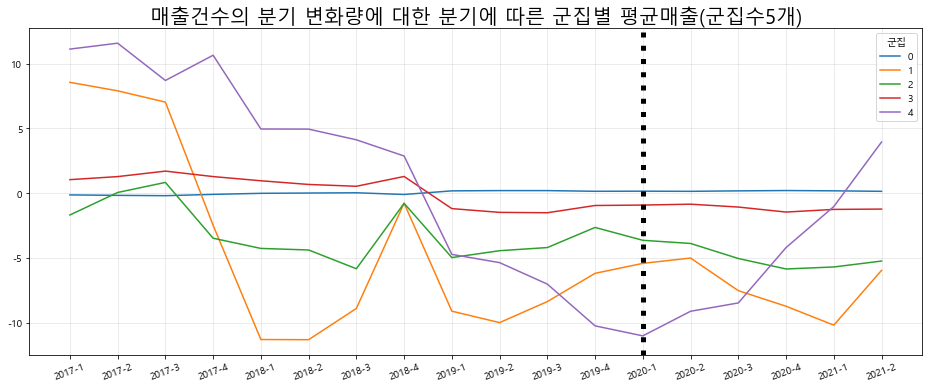

In [41]:
temp_cnt_chnage0 = temp_cnt_change.copy()
temp_cnt_chnage0 = temp_cnt_chnage0.apply(lambda x: (x-x.mean())/x.std(), axis=0)

for i in range(3,6):
    temp_cnt_final = temp_cnt_chnage0.copy()
    kmeans = KMeans(n_clusters=i, random_state=0).fit(temp_cnt_final)
    temp_cnt_final['segment'] = kmeans.labels_
    ax = temp_cnt_final.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(temp_cnt_final.columns)-1)], temp_cnt_final.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.axvline(x = 12, color = 'black', linestyle = ':',linewidth=5)
    plt.grid(alpha=0.3)
    plt.title('매출건수의 분기 변화량에 대한 분기에 따른 군집별 평균매출(군집수{}개)'.format(i) ,size=20)
    plt.show()

#### 4-(2). 매출건수변화량을 활용 / clusring: DTW()

- 분기별 변화량: 위의 매출 금액과 동일한 수식을 진행

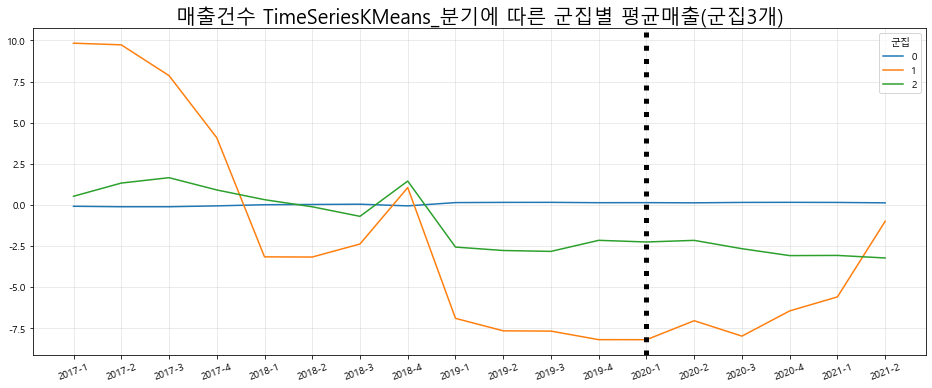

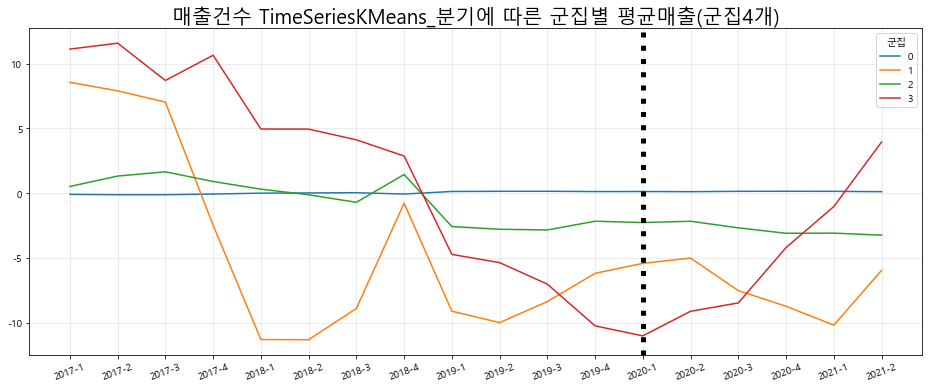

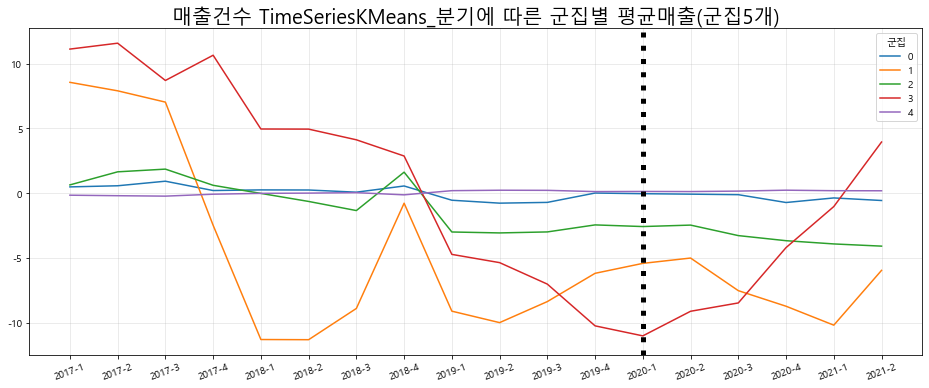

In [42]:
temp_cnt_change_4 = temp_cnt_chnage0.copy()
X = temp_cnt_change_4.to_numpy().reshape(315,18,1)
for k in range(3,6):
    km = TimeSeriesKMeans(n_clusters=k, 
                      metric="dtw", 
                      max_iter=100,
                      random_state=42)

    prediction = km.fit_predict(X)
    temp_cnt_change_4['segment'] = prediction
    ax = temp_cnt_change_4.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(temp_cnt_change_4.columns)-1)], temp_cnt_change_4.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.grid(alpha=0.3)
    plt.axvline(x = 12, color = 'black', linestyle = ':',linewidth=5)
    plt.title('매출건수 TimeSeriesKMeans_분기에 따른 군집별 평균매출(군집{}개)'.format(k),size=20)
    plt.show()

### (5)-1. 건수 분기 변화율 활용 : (2)-1과 대응

In [43]:
temp_cnt_change1 = df_cnt.set_index(['년-분기','상권_코드_명'])['분기당_평균매출건수'].unstack().transpose()

In [ ]:
begin_point_cnt = temp_cnt_change1.T.iloc[0,:]
value_cnt = temp_cnt_change1.T.div(begin_point_cnt).sub(1).round(2).mul(100).T

In [ ]:
for i in range(3,6):
    c = value_cnt.copy()
    kmeans = KMeans(n_clusters=i, random_state=0).fit(c)
    c['segment'] = kmeans.labels_
    ax = c.groupby('segment').mean().T.plot(figsize=(16,6))
    plt.xticks([i for i in range(len(c.columns)-1)], c.columns[:-1], rotation=20)
    plt.legend(loc='upper right', title='군집')
    plt.axvline(x = 16, color = 'black', linestyle = ':',linewidth=5)
    plt.grid(alpha=0.3)
    plt.title('매출금액의 분기 변화량에 대한 분기에 따른 군집별 평균매출 변화(군집수{}개)'.format(i) ,size=20)
    plt.show()